### 因子分析

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mstats
from scipy import stats
from datetime import datetime
from pandas import Series
from pandas import DataFrame
from alphalens import utils
from alphalens import plotting
from alphalens import tears
from alphalens import performance
import matplotlib as mpl
import matplotlib.pyplot as plt

### 选择日期数据

In [5]:
trading_dates = get_trading_dates('2019-01-01','2020-01-01')
trading_dates[:5]

[datetime.date(2019, 1, 2),
 datetime.date(2019, 1, 3),
 datetime.date(2019, 1, 4),
 datetime.date(2019, 1, 7),
 datetime.date(2019, 1, 8)]

### 获取因子指标

获取指定日期的数据

In [6]:
factor_name = 'pe_ratio'
stocks_set = index_components('000300.XSHG')
q = query(fundamentals.eod_derivative_indicator.pe_ratio).filter(fundamentals.eod_derivative_indicator.stockcode.in_(stocks_set))
daily_fac_data = get_fundamentals(q,trading_dates[0])

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:361: UserWarning: Panel is  removed after pandas version 0.25.0.the  default value of 'expect_df' will change to True in the future.
  warnings.warn("Panel is  removed after pandas version 0.25.0."


In [7]:
daily_fac_data.shape

(1, 1, 292)

In [8]:
daily_fac_data.iloc[0,0,0:5]

000001.XSHE     6.3581
000002.XSHE     7.8121
000063.XSHE   -11.7429
000069.XSHE     4.6255
000100.XSHE     9.8061
Name: 2019-01-02 00:00:00, dtype: object

In [11]:
df_facs_datas = DataFrame() #总表
for i in range(len(trading_dates)):
    daily_fac_data = get_fundamentals(q,trading_dates[i]).iloc[0,0,:] #每天的数据
    df_daily_fac_data = DataFrame(daily_fac_data)
    df_daily_fac_data.columns=['fac_value']
    df_daily_fac_data['date'] = trading_dates[i]
    df_facs_datas = pd.concat([df_facs_datas,df_daily_fac_data]) #拼接到总表中

In [12]:
df_facs_datas.head()

,fac_value,date
000001.XSHE,6.3581,2019-01-02
000002.XSHE,7.8121,2019-01-02
000063.XSHE,-11.7429,2019-01-02
000069.XSHE,4.6255,2019-01-02
000100.XSHE,9.8061,2019-01-02


### 格式转换，为了满足工具包要求

In [13]:
df_facs_datas = df_facs_datas.set_index(['date',df_facs_datas.index])

In [14]:
df_facs_datas.head()

fac_value
date                            
2019-01-02 000001.XSHE    6.3581
           000002.XSHE    7.8121
           000063.XSHE  -11.7429
           000069.XSHE    4.6255
           000100.XSHE    9.8061

In [15]:
series_facs_datas = df_facs_datas['fac_value']
series_facs_datas.head()

date                   
2019-01-02  000001.XSHE     6.3581
            000002.XSHE     7.8121
            000063.XSHE   -11.7429
            000069.XSHE     4.6255
            000100.XSHE     9.8061
Name: fac_value, dtype: object

In [16]:
def winsorize_series(series):
    q = series.quantile([0.02,0.98])
    if isinstance(q,pd.Series) and len(q) == 2:
        series[series<q.iloc[0]] = q.iloc[0]
        series[series>q.iloc[1]] = q.iloc[1]
    return series
def standardize_series(series):
    std = series.std()
    mean = series.mean()
    return (series-mean)/std

In [17]:
series_facs_datas = series_facs_datas.groupby(level = 'date').apply(winsorize_series)
series_facs_datas = series_facs_datas.groupby(level = 'date').apply(standardize_series)

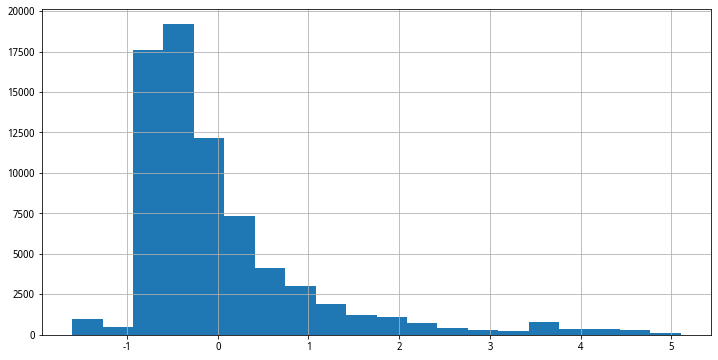

In [18]:
series_facs_datas.hist(figsize=(12,6),bins=20)

### 获取收盘价

In [24]:
price = get_price(stocks_set,start_date = '2019-01-01',end_date='2020-01-01').close
price.index.name = 'date'
price.columns.name = 'code'
price.head()

code,603501.XSHG,002007.XSHE,601992.XSHG,603160.XSHG,600406.XSHG,601328.XSHG,600893.XSHG,601857.XSHG,603156.XSHG,002024.XSHE,...,000001.XSHE,000596.XSHE,002555.XSHE,001979.XSHE,601577.XSHG,600010.XSHG,002230.XSHE,300413.XSHE,601898.XSHG,002411.XSHE
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,28.9030,19.7360,3.3112,72.6945,17.7520,5.3921,21.3698,6.9815,28.1663,9.9271,...,9.0908,52.0927,9.3726,16.2328,8.1984,1.4636,24.9680,21.1941,4.5538,19.62
2019-01-03,28.3748,19.8812,3.2324,72.1664,17.8108,5.4967,21.9861,7.0303,28.1933,9.9667,...,9.1798,50.1589,8.8432,16.3293,8.2372,1.4835,25.3669,21.1824,4.5931,19.24
2019-01-04,29.2319,20.6472,3.3014,72.2461,18.2516,5.5728,22.1054,7.1083,28.4296,10.2141,...,9.6447,51.5106,9.3530,16.7536,8.5481,1.5134,27.0520,21.4824,4.6620,19.44
2019-01-07,30.5575,20.5877,3.3605,73.6910,19.1431,5.5442,22.8111,7.1375,28.6455,10.2240,...,9.6348,51.6290,9.5589,16.9948,8.6452,1.5134,29.1859,22.5647,4.7112,19.52
2019-01-08,29.8797,20.7396,3.3507,74.3388,18.7709,5.5632,22.4234,7.1473,28.4836,10.1745,...,9.5557,52.8030,9.4118,17.0141,8.5578,1.5034,28.9366,22.3530,4.7013,19.55


### 格式转换

In [25]:
facs_data_analysis = utils.get_clean_factor_and_forward_returns(series_facs_datas,price)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [26]:
facs_data_analysis.head()

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362 -0.694558   
           000002.XSHE  0.007115  0.059832  0.063601 -0.645023   
           000063.XSHE -0.039877  0.018405  0.038344 -0.838543   
           000069.XSHE  0.001678  0.045231  0.033499 -0.753585   
           000100.XSHE  0.007967  0.123473  0.067702 -0.577091   

                        factor_quantile  
date       asset                         
2019-01-02 000001.XSHE                1  
           000002.XSHE                1  
           000063.XSHE                1  
           000069.XSHE                1  
           000100.XSHE                2

In [27]:
IC =  performance.factor_information_coefficient(facs_data_analysis)
IC.head()

,1D,5D,10D
date,,,
2019-01-02,0.076137,0.139218,0.137872
2019-01-03,0.088709,0.168826,0.087542
2019-01-04,0.194145,0.014174,-0.075710
2019-01-07,0.012150,-0.173601,-0.192336
2019-01-08,-0.184939,-0.059751,-0.234073


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc886cfef98>,
      dtype=object)

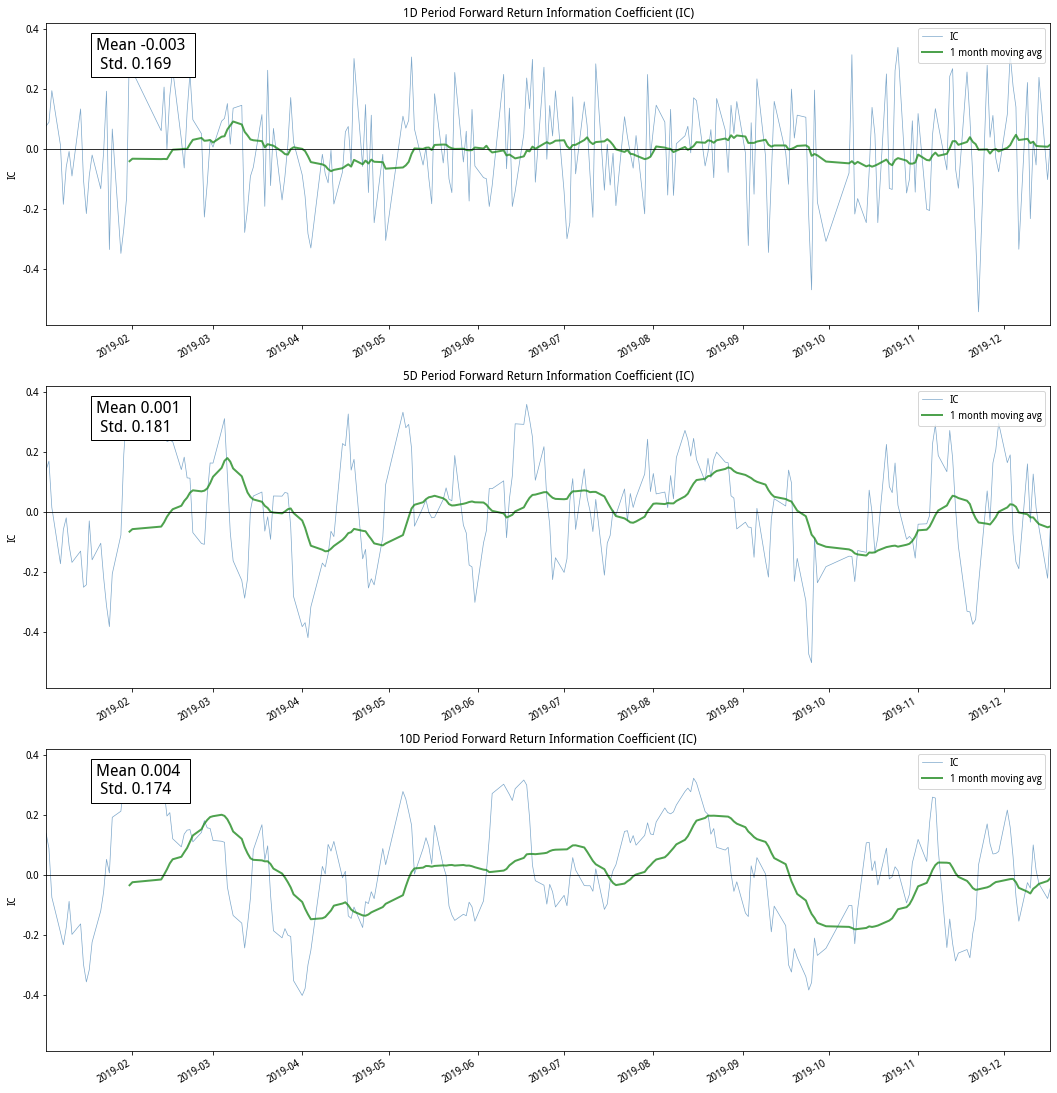

In [28]:
plotting.plot_ic_ts(IC)

### 因子收益率

Returns Analysis


,1D,5D,10D
Ann. alpha,0.058,0.035,0.033
beta,0.092,0.112,0.124
Mean Period Wise Return Top Quantile (bps),3.616,3.155,2.906
Mean Period Wise Return Bottom Quantile (bps),-3.784,-3.418,-3.170
Mean Period Wise Spread (bps),7.400,6.555,6.059


/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeInd

<Figure size 432x288 with 0 Axes>

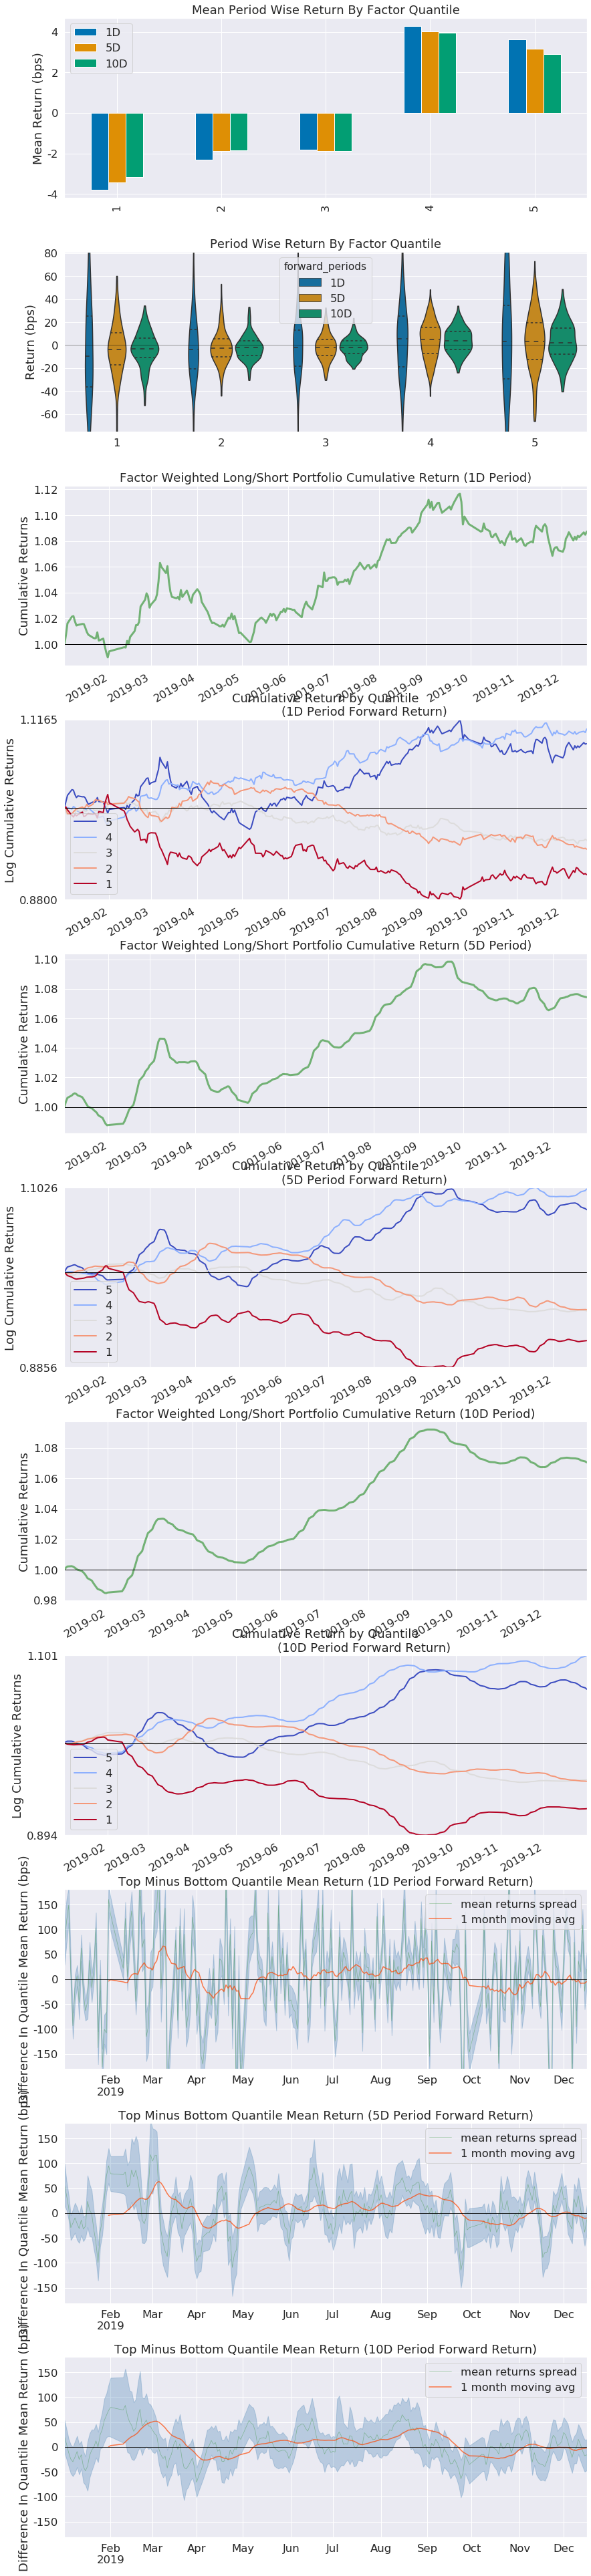

In [29]:
tears.create_returns_tear_sheet(facs_data_analysis)

In [30]:
performance.factor_returns(facs_data_analysis).head()

,1D,5D,10D
date,,,
2019-01-02,0.007277,0.018257,0.013301
2019-01-03,0.008791,0.007251,0.001946
2019-01-04,0.005172,-0.001219,-0.009361
2019-01-07,0.000395,-0.005371,-0.016912
2019-01-08,-0.003965,-0.006173,-0.017731


In [31]:
performance.factor_returns(facs_data_analysis).head().mean()

1D     0.003534
5D     0.002549
10D   -0.005751
dtype: float64